In [1]:
import numpy as np
import pandas as pd
import astropy.io.fits as apfits
import astropy.visualization as apvis
import astropy.nddata as apnndd
import astropy.table as aptable
import astropy.wcs as apwcs
import astropy.units as apunits
import astropy.coordinates as apcoords
import matplotlib.pyplot as mplplot
import matplotlib.patches as mplpatches
import glob
import os
import scipy as sp
import scipy.optimize as spopt
import copy
import grismconf
import sys
import spectres

# Accessing Fengwu Data Files (OneDrive)

## Load in frame file and designate variables of the filter, grism and module of the input frame file from the header

Comments on file:
- Each file contains multiple headers! SEE THESE THROUGH print(Frame) THEN CHECK INDIVIDUALLY THROUGH Frame[0] or ['PRIMARY'] 
- To see the name of headers past ['PRIMARY'], see "EXTNAME" in their header
- Header has all the secrets (as per)
- I believe the reason we cannot drizzlepac the frames together is that the file type (Frame['PRIMARY'].header['FILETYPE']) = 'raw'
- When it comes to using drizzlepac, the "Dither Information" keywords will be essential in combining the correct files
- File name origins outlined in header "Observation identifiers" keywords
- CDRS Information at bottom header must be files set in MIRAGE - ask Fengwu?


In [2]:
# file_name = "/Users/zx446701/OneDrive - The Open University/Ice_Age/Fengwu_Sims_2/F322W2_grism/F322W2_Level15_Frames/jw01309024002_01101_00019_nrca5_rate_lv1.5.fits"
file_name = "/Users/zx446701/OneDrive - The Open University/Ice_Age/Fengwu_Sims_2/F444W_grism/F444W_Level15_Frames/jw01309025001_01101_00002_nrcb5_rate_lv1.5.fits"
with apfits.open(file_name) as Frame:
    # print(repr(Frame["PRIMARY"].header))
    filter_ = Frame['PRIMARY'].header['FILTER'].strip()
    # [-1] needed to extract just either R or C
    # CHANGE DIRECTION TO GRISM FOR CLARITY
    direction = Frame['PRIMARY'].header['PUPIL'].strip()[-1]
    module = Frame['PRIMARY'].header['MODULE'].strip()
    dither = Frame['PRIMARY'].header['PATT_NUM']
    # SUBPIXNUM Missing from new sims!!!
    # subpixel = Frame['PRIMARY'].header['SUBPXNUM']

## Create variables for the folders needed throughout script

- Will be used for file path joining

In [3]:
# All 192 simulated frames produced by MIRAGE - total = 192 frames as 4 observations each have 2 Grisms, 2 modules, 3 Primary Dithers each with 4 subpixel dithers.
# Of the 4 observations 2 are with the F322W2 (Water) Filter and F444W (CO+CO2 filter), making 96 frames per filter. This is how the folders are split.
frameFitsDir = f"/Users/zx446701/OneDrive - The Open University/Ice_Age/Fengwu_Sims_2/{filter_}_grism/{filter_}_Level15_Frames/"

# Source list for every frame within the simulation - WANT TO CREATE OUR OWN SOURCE FROM DIRECT IMAGES
frameListDir = f"/Users/zx446701/OneDrive - The Open University/Ice_Age/Fengwu_Sims_2/{filter_}_grism/{filter_}_List"


## Import PSF model grid modules

In [4]:
# Use source code to look into utils etc.
from webbpsf.utils import to_griddedpsfmodel
from webbpsf.gridded_library import display_psf_grid
# Take specific instrument, module, filter and detector PSF fits files 
# and turn into a grid of how the PSF changes with position on detector array
# NUMBER OF DETECTOR IS IN NRCA5 - 5 IS LW DETECTOR 1-4 IS SW
# ONLY 5 REQUIRED FOR WFSS AS ONLY DETECTOR ABLE TO DO THIS
if filter_ == 'F322W2':
    grid = to_griddedpsfmodel(
        f"/Users/zx446701/OneDrive - The Open University/Ice_Age/Fengwu Data/gridded_psf_library/nircam_nrc{module.lower()}5_{filter_.lower()}_clear_fovp47_samp5_npsf16_requirements_realization0.fits"
    )
else:
    grid = to_griddedpsfmodel(
    f"/Users/zx446701/OneDrive - The Open University/Ice_Age/Fengwu Data/gridded_psf_library/nircam_nrc{module.lower()}5_{filter_.lower()}_clear_fovp61_samp5_npsf16_requirements_realization0.fits"
    )
    

/Users/zx446701/opt/anaconda3/envs/astroconda/lib/python3.7/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/Users/zx446701/opt/anaconda3/envs/astroconda/lib/python3.7/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-040-001 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-044
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


# Define functions to extract the source list, along with sky and pixel coordinates within the images


## Function creates pathname of input frame file and opens as a pandas dataframe 
Can I find the information for what each column represents in this file?

10 columns total: 

Col 0: Source ID ??

Col 1-4: Coords (RA and Dec in hms, dms then deg, deg)

Col 5-6: Pixel Coordinates

Col 7-10: No idea

- Extracts name of the file from the full pathname
        print(os.path.basename(file_name))
- Creates list of each component of the file name SPLIT by _ (each as a string) and selects the first 4 components
        print(os.path.basename(file_name).split('_')[:4])
- Rejoins the 4 extracted components by JOINing them with _
        print('_'.join(os.path.basename(file_name).split('_')[:4]))

In [5]:
def getSourceListForImage(image, frameListDir):
    listPath = os.path.join(
        frameListDir,
        f"{'_'.join(os.path.basename(image).split('_')[:4])}_uncal_pointsources.list",
    )
    return pd.read_csv(listPath, delim_whitespace=True, comment="#", header=None)

## Function extracting Sky Coordinates from source list

- Identify all the values within col 3 and 4 of pandas df
        sourceList.loc[:, [3, 4]]
- Turns this into a numpy array
        sourceList.loc[:, [3, 4]].to_numpy()
- Finally tranpose the the 2D array to a list of RA values and Dec values
        sourceList.loc[:, [3, 4]].to_numpy().T
- Starred list indicates 0 and 1 lists within of 2d array ([[0],[1]]) inputted here so every sources RA and Dec can be inputted and coverted into astropy SkyCoord form
        apcoords.SkyCoord(*sourceList.loc[:, [3, 4]].to_numpy().T, frame=apcoords.ICRS, unit=apunits.deg)


In [6]:
def getSourceCoordsForImage(image, frameListDir):
    sourceList = getSourceListForImage(image, frameListDir) # Previous Function
    coords = apcoords.SkyCoord(
        *sourceList.loc[:, [3, 4]].to_numpy().T, frame=apcoords.ICRS, unit=apunits.deg
    )
    return coords

## Function extracting Pixel Coords from source list

- Does the same as above except it does not need to transpose values as no additional conversion function needed

In [7]:
def getSourcePixelsForImage(image, frameListDir):
    sourceList = getSourceListForImage(image, frameListDir)
    pixels = sourceList.loc[:, [5, 6]].to_numpy()
    
    return pixels


### This function is not used

Just calculates the length and width of a trace from a given x,y pixel position 

In [8]:
def computeTrace(pixels, fac=100, filter_="F322W2", module="A", direction="R", simYDisp=False, order=1):
    # Locate config File for the module and grism direction 
    confFile = f"/Users/zx446701/OneDrive - The Open University/Ice_Age/Fengwu_Sims_2/GRISM_NIRCAM-master/V3/NIRCAM_{filter_}_mod{module}_{direction}.conf"
    # Class to read and hold GRISM configuration info
    conf = grismconf.Config(confFile)
    # Found from GRISMCONF README file - see link above
    # Middle section - number of pixels from end to start in X direction
    # 1/ middle = slighting trace by number of pixels
    # /fac is for splitting by subpixel amounts and oversampling
    dt = np.abs(1 / (1 + conf.DISPX(f'+{order}', *pixels, 1) - conf.DISPX(f'+{order}', *pixels, 0)) / fac)
    # t is the trace and how much of it is covered (0 to 1 is the full trace)
    t = np.arange(0, 1, dt)

    # DISP(X,Y,L) = DISPERSION POLYNOMIAL (X direction, Y, Full Length)
    # order, x0, y0, steps along dispersion between 0 and 1
    # X disp polynomial
    dxs = conf.DISPX(f"+{order}" *pixels, t)
    # Y disp polynomial 
    dys = conf.DISPY(f"+{order}" *pixels, t)
    # Compute wavelength of each pixel
    wavs = conf.DISPL(f"+{order}" *pixels, t)

    return (
        pixels[0] + dxs,
        pixels[1] + dys if simYDisp else np.full_like(dys, pixels[1]),
        wavs,
    )

### Function returning the pixels and wavelengths of those pixels of a source dispersed in the R direction


In [9]:
def computeTraceWLR(pixels, filter_="F322W2", module="A", simYDisp=False, order=1):
    # Locate config File for the filter, module and grism direction 
    confFile = f"/Users/zx446701/OneDrive - The Open University/Ice_Age/Fengwu_Sims_2/GRISM_NIRCAM-master/V3/NIRCAM_{filter_}_mod{module}_R.conf"
    # Class to read and hold GRISM configuration info
    conf = grismconf.Config(confFile)
    # Found from GRISMCONF README file - see link above


    # dt = 1/(conf.DISPX(f'+{order}', *pixels,0)-conf.DISPX(f'+{order}', *pixels,1)) / fac
    # t = np.arange(0,1,dt)

    dxs0 = conf.DISPX(f'+{order}',*pixels, 0)

    dxs1 = conf.DISPX(f'+{order}', *pixels, 1)
    
    # np.floor rounds to lower value
    # np.ceil rounds to higher value
    # Want this so full trace is picked up in all pixels
    # ARE THESE MEANT TO BE THE OTHER WAY ROUND?
    dxs = np.arange(np.ceil(dxs0)+1,np.floor(dxs1)).astype(int)

    ts = conf.INVDISPX(f'+{order}',*pixels,dxs)

    wavs = conf.DISPL(f'+{order}',*pixels,ts)

    return (
        pixels[0] + dxs,
        wavs,
    )

### Function returning the pixels and wavelengths of those pixels of a source dispersed in the C direction


In [10]:
def computeTraceWLC(
    pixels,
    filter_="F322W2",
    module="A",
    simYDisp=False,
    order=1
):
    
    # Locate config File for the filter, module and grism direction 
    confFile = f"/Users/zx446701/OneDrive - The Open University/Ice_Age/Fengwu_Sims_2/GRISM_NIRCAM-master/V3/NIRCAM_{filter_}_mod{module}_C.conf"
    # Class to read and hold GRISM configuration info
    conf = grismconf.Config(confFile)
    # Found from GRISMCONF README file - see link above


    # dt = 1/(conf.DISPX(f'+{order}', *pixels,0)-conf.DISPX(f'+{order}', *pixels,1)) / fac
    # t = np.arange(0,1,dt)

    dys0 = conf.DISPY(f'+{order}',*pixels, 0)

    dys1 = conf.DISPY(f'+{order}', *pixels, 1)
    
    # np.floor rounds to lower value
    # np.ceil rounds to higher value
    # Want this so full trace is picked up in all pixels
    # ARE THESE MEANT TO BE THE OTHER WAY ROUND?
    dys = np.arange(np.ceil(dys0)+1,np.floor(dys1)).astype(int)

    ts = conf.INVDISPY(f'+{order}',*pixels,dys)

    wavs = conf.DISPL(f'+{order}',*pixels,ts)

    return (
        pixels[1] + dys,
        wavs,
    )

### Function to choose between R or C wavelengths required

In [11]:
def computeTraceWL(
    pixels,
    filter_="F322W2",
    module="A",
    direction="R",
    simYDisp=False,
    order=1
):
    if direction == "R":
        return computeTraceWLR(pixels=pixels,filter_=filter_,module=module,simYDisp=simYDisp,order=order)
    else:
        return computeTraceWLC(pixels=pixels,filter_=filter_,module=module,simYDisp=simYDisp,order=order)

### Function to calculate the trace box of a source dispersed in the R direction

In [12]:
def computeTraceBoxR(
    # Pixels of source being traced (x0, y0)
    pixels,
    # Not sure this is needed
    fac=100,
    # Change filter depending on filter used for observation
    filter_="F322W2", 
    # Change module depending on module used for observation
    module="A",
    # Is this needed?
    simYDisp=False,
    # Box around expected trace 
    returnRect=True,
    # Height 50 pixels as PSF modelled 50x50 pixels
    cross_disp_size=50,
    # Set Order desired to be computed for
    order=1,
    # Need some guidance on what this is !
    **patchkws,
):
    confFile = f"/Users/zx446701/OneDrive - The Open University/Ice_Age/Fengwu_Sims_2/GRISM_NIRCAM-master/V3/NIRCAM_{filter_}_mod{module}_R.conf"
    conf = grismconf.Config(confFile)
    # X and Y disp polynomials with 2 steps, the start [0] and end [1] of the trace
    dxs = conf.DISPX(f'+{order}', *pixels, np.array([0, 1]))
    # Keep in in case the JWST dispersion is curved and we need to trace the change in the curve
    dys = conf.DISPY(f'+{order}', *pixels, np.array([0, 1]))
    
    #Locating the centre of the trace [0.5]
    centrePix = conf.DISPX(f'+{order}', *pixels, np.array([0.5]))

    if returnRect:
#         mplplot.scatter(pixels[0]+centrePix[0], pixels[1],c='green')
        return mplpatches.Rectangle(
            # x0,y0 in bottom left of rectangle
            (pixels[0] + dxs[0], pixels[1] - (cross_disp_size // 2)),
            # width of rectangle 
            dxs[1] - dxs[0],
            # height of box (PSF width 50 pixels)
            cross_disp_size,
            **patchkws,
        )
    # Returns Central x and y of trace and dimensions of tracebox (height, width)
    return (pixels[0]+centrePix[0], pixels[1]), (cross_disp_size, abs(dxs[1] - dxs[0]))

### Function to calculate the trace box of a source dispersed in the C direction

In [13]:
def computeTraceBoxC(
    # Pixels of source being traced (x0, y0)
    pixels,
    # Not sure this is needed
    fac=100,
    # Change filter depending on filter used for observation
    filter_="F322W2",
    # Change module depending on module used for observation
    module="A",
    # Is this needed?
    simYDisp=False,
    # Box around expected trace 
    returnRect=True,
    # Height 50 pixels as PSF modelled 50x50 pixels
    cross_disp_size=50,
    # Set Order desired to be computed for
    order=1,
    # Need some guidance on what this is !
    **patchkws,
):
    confFile = f"/Users/zx446701/OneDrive - The Open University/Ice_Age/Fengwu_Sims_2/GRISM_NIRCAM-master/V3/NIRCAM_{filter_}_mod{module}_C.conf"
    conf = grismconf.Config(confFile)
    # X and Y disp polynomials with 2 steps, the start and end of the trace
    dxs = conf.DISPX(f'+{order}', *pixels, np.array([0, 1]))
    # Keep in in case the JWST dispersion is curved and we need to trace the change in the curve
    dys = conf.DISPY(f'+{order}', *pixels, np.array([0, 1]))
    
    #Locating the centre of the trace 
    centrePix = conf.DISPY(f'+{order}', *pixels, np.array([0.5]))

    if returnRect:
#         mplplot.scatter(pixels[0]+centrePix[0], pixels[1],c='green')
        return mplpatches.Rectangle(
            # x0,y0 in bottom left of rectangle
            (pixels[0] - cross_disp_size // 2, pixels[1] + dys[0]),
            # width of rectangle 
            cross_disp_size,
            # height of box (PSF width 50 pixels)
            dys[1] - dys[0],
            **patchkws,
        )
    return (pixels[1]+centrePix[0], pixels[0]), (cross_disp_size, abs(dys[1] - dys[0]))

### Function to choose between R or C trace box required

In [14]:
def computeTraceBox(
    # Pixels of source being traced (x0, y0)
    pixels,
    # Not sure this is needed
    fac=100,
    # Change filter depending on filter used for observation
    filter_="F322W2",
    # Change module depending on module used for observation
    module="A",
    # Change Direction depending on disperser used for observation
    direction="R",
    # Is this needed?
    simYDisp=False,
    # Box around expected trace 
    returnRect=True,
    # Height 50 pixels as PSF modelled 50x50 pixels
    cross_disp_size=50,
    # Set Order desired to be computed for
    order=1,
    # Need some guidance on what this is !
    **patchkws,
):
    if direction == "R":
        return computeTraceBoxR(pixels=pixels,fac=fac,filter_=filter_,module=module,simYDisp=simYDisp,returnRect=returnRect,cross_disp_size=cross_disp_size,order=order,**patchkws)
    else:
        return computeTraceBoxC(pixels=pixels,fac=fac,filter_=filter_,module=module,simYDisp=simYDisp,returnRect=returnRect,cross_disp_size=cross_disp_size,order=order,**patchkws)

### Function returning Trace Box of 1st Order dispersions 

In [15]:
def compute1stOrderTraceBox(
    # Pixels of source being traced (x0, y0)
    pixels,
    # Not sure this is needed
    fac=100,
    # Change filter depending on filter used for observation
    filter_="F322W2",
    # Change module depending on module used for observation
    module="A",
    # Change Direction depending on disperser used for observation
    direction="R",
    # Is this needed?
    simYDisp=False,
    # Box around expected trace 
    returnRect=True,
    # Height 50 pixels as PSF modelled 50x50 pixels
    cross_disp_size=50,
    # Need some guidance on what this is !
    **patchkws,
):
    return computeTraceBox(pixels,fac,filter_,module,direction,simYDisp,returnRect,cross_disp_size,1,**patchkws)

### Function returning Trace Box of 2nd Order dispersions 

In [16]:
def compute2ndOrderTraceBox(
    # Pixels of source being traced (x0, y0)
    pixels,
    # Not sure this is needed
    fac=100,
    # Change filter depending on filter used for observation
    filter_="F322W2",
    # Change module depending on module used for observation
    module="A",
    # Change Direction depending on disperser used for observation
    direction="R",
    # Is this needed?
    simYDisp=False,
    # Box around expected trace 
    returnRect=True,
    # Height 50 pixels as PSF modelled 50x50 pixels
    cross_disp_size=50,
    # Need some guidance on what this is !
    **patchkws,
):
    if filter_ == "F322W2":
        return computeTraceBox(pixels,fac,filter_,module,direction,simYDisp,returnRect,cross_disp_size,2,**patchkws)
    else:
        print("You have made an error. 2nd Order spectra only occur in F332W2 frames. Please comment out patch.")

# Fitting Code Begins

## Set up required variables for code
Retrieve each sources direct pixel and sky coordinates and create a Pandas dataframe of the direct pixel coords for manipulation later.

In [17]:
# Get sources from all images loaded into notebook
directPixels = getSourcePixelsForImage(file_name, frameListDir)
DPdf = pd.DataFrame(directPixels)
sourceCoords = getSourceCoordsForImage(file_name, frameListDir)

## Create dataframe of x pixels at which each source's 1st and 2nd order trace begins and ends

In [18]:
x1st = []
x2nd = []
# y = []

for directPixel in directPixels:
    confFile = f"/Users/zx446701/OneDrive - The Open University/Ice_Age/Fengwu_Sims_2/GRISM_NIRCAM-master/V3/NIRCAM_{filter_}_mod{module}_{direction}.conf"
    conf = grismconf.Config(confFile)
    # X and Y disp polynomials with 2 steps, the start and end of the trace for 1st and 2nd order spectra
    # Because the grismconf.config() function knows which filter is used from the file name,
    # so the conf.DISPX and conf.DISPY functions work as needed
    if direction == "R":
        x1st.append(directPixel[0] + conf.DISPX("+1", *directPixel, np.array([0, 1])))
    
        x2nd.append(directPixel[0] + conf.DISPX("+2", *directPixel, np.array([0, 1])))
    
    elif direction == "C":
        x1st.append(directPixel[1] + conf.DISPY("+1", *directPixel, np.array([0, 1])))
    
        x2nd.append(directPixel[1] + conf.DISPY("+2", *directPixel, np.array([0, 1])))
    else:
        print("You have made an error. Direction must be R or C.")

# May need to include this if traces are curved
# Is the Y needed for this?
#     y.append(int(directPixel[1] + conf.DISPY("+1", *directPixel, np.array([0, 1]))))

# Turn the list into a dataframe
dfx1st = pd.DataFrame(x1st)
# display(dfx1st)

# Rename the columns for pixel trace start and endpoints
dfx1st = dfx1st.rename(columns = {0 : "low_WL", 1 : "high_WL"})

# The X and Y pixels coordinates of the sources
dfx1st["Direct_X"] = DPdf[0]
dfx1st["Direct_Y"] = DPdf[1]

# The Sky Coordinates of sources
dfx1st["RA"] = sourceCoords.ra
dfx1st["Dec"] = sourceCoords.dec

# Order of Traces
dfx1st["Order"] = 1

# Position of source within Fengwu file - CHECK THIS!!!
dfx1st["FengwuID"] = dfx1st.index

# Dataframe sorted by trace starting furthest to the left
dfx1st = dfx1st.sort_values(by="low_WL")
# True or false to come next
if filter_ == "F322W2":
    dfx2nd = pd.DataFrame(x2nd)
    # Rename the columns for pixel trace start and endpoints
    dfx2nd = dfx2nd.rename(columns = {0 : "low_WL", 1 : "high_WL"})
    # The X and Y pixels coordinates of the sources
    dfx2nd["Direct_X"] = DPdf[0]
    dfx2nd["Direct_Y"] = DPdf[1]
    # The Sky Coordinates of sources
    dfx2nd["RA"] = sourceCoords.ra
    dfx2nd["Dec"] = sourceCoords.dec
    # Order of Trace
    dfx2nd["Order"] = 2
    # Position of source with Fengwu file
    dfx2nd["FengwuID"] = dfx2nd.index

    # Dataframe sorted by trace starting furthest to the left
    dfx2nd = dfx2nd.sort_values(by="low_WL")
    # dfx2nd


    dfx = pd.concat([dfx2nd,dfx1st])
    
else:
    dfx = dfx1st


In [38]:
dfx[(dfx["Direct_X"]>1500) & (dfx["Direct_X"]<1800) & (dfx["Direct_Y"]>1200) & (dfx["Direct_Y"]<1500)]

,low_WL,high_WL,Direct_X,Direct_Y,RA,Dec,Order,FengwuID
51,1686.109502,341.487988,1529.735,1407.246,166.619380,-77.395317,1,51
37,1784.084502,439.462988,1627.710,1459.196,166.628130,-77.395599,1,37
224,1844.681502,500.059988,1688.307,1399.368,166.631070,-77.394264,1,224
288,1860.595502,515.973988,1704.221,1240.753,166.628010,-77.391563,1,288
145,1915.730502,571.108988,1759.356,1206.468,166.631240,-77.390678,1,145
363,1949.866502,605.244988,1793.492,1364.663,166.638042,-77.393083,1,363


## Plot Check of the uploaded files 

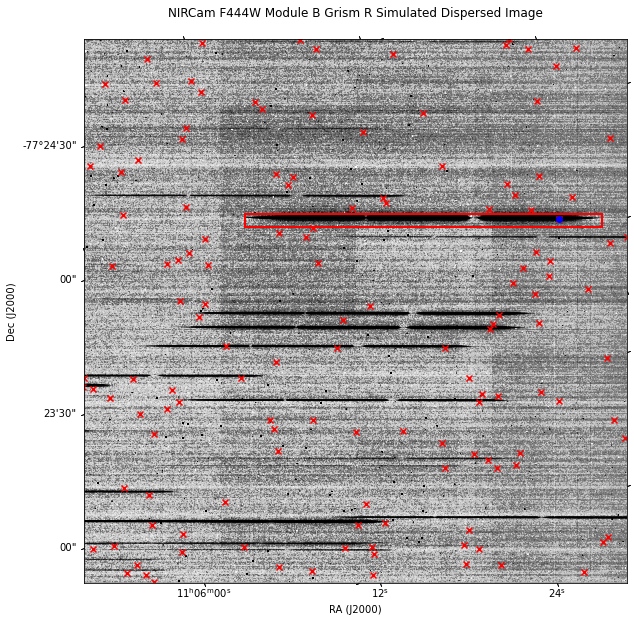

In [40]:
with apfits.open(file_name) as test:
    figure = mplplot.figure(figsize=(10, 10))
    ax = figure.add_subplot(1, 1, 1, projection=apwcs.WCS(test["SCI"].header))    
    ax.imshow(
        # SCI is the images from the simulation
        test["SCI"].data,
        norm=apvis.ImageNormalize(
            stretch=apvis.HistEqStretch(data=test["SCI"].data),
            interval=apvis.ZScaleInterval(),
        ),
        cmap="Greys",
    )
        
    # Set image limits
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
#     sourceCoords = getSourceCoordsForImage(file_name, frameListDir)
        
         # Plot sources on FOV
    ax.scatter(
        sourceCoords.ra,
        sourceCoords.dec,
        marker="x",
        c="r",
        transform=ax.get_transform("world"),
    )
    # ax.set_title(os.path.basename(file_name))
    ax.set_title(f"NIRCam {filter_} Module {module} Grism {direction} Simulated Dispersed Image",y=1.03)
    
    ax.scatter(
        dfx["RA"][dfx['FengwuID']==363],
        dfx["Dec"][dfx['FengwuID']==363],
        marker="o",
        c="b",
        transform=ax.get_transform("world")
    )    
#     directPixels = getSourcePixelsForImage(file_name, frameListDir)
#     print(file_name, directPixels[24],directPixels[77] if len(directPixels) > 50 else "Short")
        
    # for loop to create trace boxes for each source within source list
    # HOW DO WE CHANGE FOR C DIRECTION?? NEED TO LOAD C DATA???
    # where is sourceId defined? Within file_name???
    for sourceId, directPixel in enumerate(directPixels):
        traceBox1st = compute1stOrderTraceBox(
            directPixel,
            filter_=filter_,
            # module=os.path.basename(file_name).split("_")[3][-2].upper(),
            module=module,
            direction=direction,
            ec="orange",
            lw="2",
            fc="none",
        )
        # ax.add_patch(traceBox1st)
        
        traceBoxLast = compute1stOrderTraceBox(
            (dfx1st['Direct_X'][dfx1st['FengwuID']==363],
            dfx1st['Direct_Y'][dfx1st['FengwuID']==363]),
            filter_=filter_,
            # module=os.path.basename(file_name).split("_")[3][-2].upper(),
            module=module,
            direction=direction,
            ec="red",
            lw="2",
            fc="none",
        )
        ax.add_patch(traceBoxLast)
        
        # traceBox2nd = compute2ndOrderTraceBox(
        #     directPixel,
        #     filter_=filter_,
        #     module=module,
        #     direction=direction,
        #     ec="blue",
        #     lw="2",
        #     fc="none",
        # )
        # ax.add_patch(traceBox2nd)
        
        # Removing limits shows that all sources in list have traces calculated for them
        # Therefore missing traces must be due to them missing in source list which
        # will not be a problem once NIRCam Pre-imaging has been achieved
    ax.set_xlabel("RA (J2000)")
    ax.set_ylabel("Dec (J2000)")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
# mplplot.savefig("Trace_Box_Simulated_FOV.png")

# Plot check of data within images 
In "data", the rows are the outside of the 2d array and columns on the inside - see .data[:,100] 

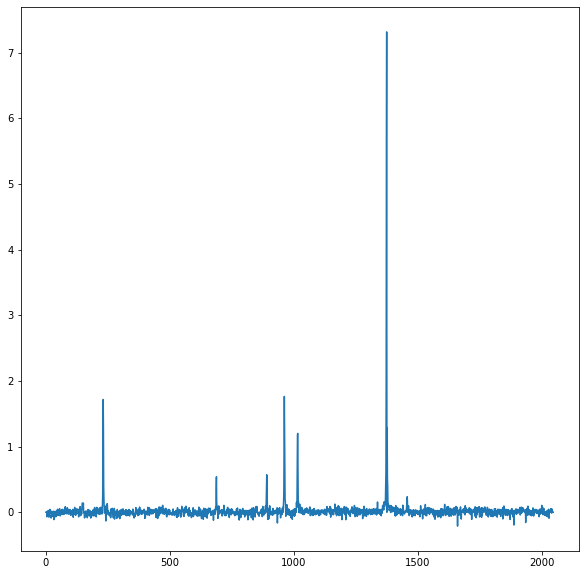

In [20]:
with apfits.open(file_name) as test:
    data = test["SCI"].data
    figure = mplplot.figure(figsize=(10, 10))
    ax = figure.add_subplot(1, 1, 1, )#projection=apwcs.WCS(test["SCI"].header))    
#     ax.imshow(
#         # SCI is the images from the simulation
#         test["SCI"].data[:,100:101],
#         norm=apvis.ImageNormalize(
#             stretch=apvis.HistEqStretch(data=test["SCI"].data[:,100:101]),
#             interval=apvis.ZScaleInterval(),
#         ),
#         cmap="Greys",
#     )
    ax.plot(
    test["SCI"].data[1500,:] if direction == "C" else test["SCI"].data[:,1000] if direction =="R" else np.zero(data.shape[0]))

# Chi Squared fit function defined to find best fit parameters (Flux only at the moment not best fit Y Pixel)

In [21]:
# Chi squared function to test parameters fit

# norms = initial parameters
# cutoutSlice = column we are fitting
# errorSlice = errors associated with the column pixels
# psfs = 
# means = mean position of psfs (Dispersion Direction Direct Pixel)



def fitFunction(norms, cutoutSlice, errorSlice, psfs, means,
#                 offsets,
                plotme=False):
#     figure = mplplot.figure(figsize = (15,15))
#     mplplot.plot(cutoutSlice, label='Cut')
#     mplplot.plot(errorSlice, label="err")
    # Error Mask to simulate likely errors when checking for what was causing incorrect fits
#     error_mask = np.ones_like(cutoutSlice)*1000
    selection = errorSlice > 0
    model = np.zeros_like(cutoutSlice)
    
#     for norm, psf, mean, offset in zip(norms, psfs, means, offsets):
    for norm, psf, mean in zip(norms, psfs, means):
        # May be better interpolated below
#         print(mean)
#         print(psf.size // 2)
#         print(model[max(0, int(mean) - psf.size // 2) : min(cutoutSlice.size, int(mean) + psf.size // 2)].size)
#         error_mask[int(mean) - psf.size // 2 : int(mean) + psf.size // 2] = 0.1
        # Model for a single column with potentially many traces passing through
        # Artificially making mean an integer - need a better approach.
        # WHAT SHOULD WE DO INSTEAD?
        model[int(mean) - psf.size // 2 : int(mean) + psf.size // 2] += norm * psf
    
    if plotme:
        fig, ((ax1),(ax2)) = mplplot.subplots(figsize=(10,20),nrows = 2, ncols =1)
        ax1.plot(cutoutSlice, label="Data")
        ax1.plot(model,label="Initial Model")
        ax1.legend()
        ax2.plot(errorSlice,label="Errors")
    return np.nansum(
        ((model[selection] - cutoutSlice[selection]) / errorSlice[selection]) ** 2
    )



# Single cutout could use a defined PSF function but this is now within the code in the cell below

# def simplePsfMethod(cutout, error, psfs, xDispRange, ):
#     return[
#         spopt.minimize(
#             # parameters for function as a list in square brackets - part that varies
#             # if fitting multiple sources within box, need parameters per source
#             # This is the 'norm' within fitFunction
#             fitFunction,
#             [],
#             # Arguments - the constants 
#             (cutoutSlice[xDispRange], errorSlice[xDispRange], psfs[xDispRange]),
#         ).x[0]
#         for cutoutSlice, errorSlice in zip(cutout.T, error.T)
#     ]

# FITTING CODE

In [22]:
%%time
with apfits.open(file_name) as test:
    
    # Created array for results
    
    # Mask selects the sources that are within a 1/2 PSF width from edge (25 pixels) as we cannot fit sources closer in than this 
    # Might need to revisit this choice for potential recovery of source's data for combination with other grism dispersions
    
    # CONDITIONS CUT OFF SOURCES WITH TRACES OUTSIDE OF IMAGE BOUNDS
    if filter_ == "F444W" and direction == "R":
        mask = (dfx.Direct_Y >= 30) & (dfx.Direct_Y < test["SCI"].data.shape[1]-30)  & (dfx.Direct_X >= -1344) & (dfx.Direct_X <= 2047)
        trimmed_dfx = dfx[mask.to_numpy()]
        image_data_view = enumerate(zip(test["SCI"].data.T, test["ERR"].data.T))
        initial_trace_location = trimmed_dfx.Direct_Y
        
    elif filter_ == "F444W" and direction == "C":
        mask = (dfx.Direct_X >= 30) & (dfx.Direct_X < test["SCI"].data.shape[0]-30) & (dfx.Direct_Y >= -1344) & (dfx.Direct_Y <= 2047)
        trimmed_dfx = dfx[mask.to_numpy()]
        image_data_view = enumerate(zip(test["SCI"].data, test["ERR"].data))
        initial_trace_location = trimmed_dfx.Direct_X
        
    elif filter_ == "F322W2" and direction == "R":
        mask = (dfx.Direct_Y >= 30) & (dfx.Direct_Y < test["SCI"].data.shape[1]-30)  & (dfx.Direct_X >= 0) & (dfx.Direct_X <= 2047+1743)
        trimmed_dfx = dfx[mask.to_numpy()]
        image_data_view = enumerate(zip(test["SCI"].data.T, test["ERR"].data.T))
        initial_trace_location = trimmed_dfx.Direct_Y
    
    elif filter_ == "F322W2" and direction == "C":
        mask = (dfx.Direct_X >= 30) & (dfx.Direct_X < test["SCI"].data.shape[0]-30) & (dfx.Direct_X >= 0) & (dfx.Direct_X <= 2047+1743)
        trimmed_dfx = dfx[mask.to_numpy()]
        image_data_view = enumerate(zip(test["SCI"].data, test["ERR"].data))
        initial_trace_location = trimmed_dfx.Direct_X
        
    else:
        print("You have made an error.")
    
    num_data_points = np.nansum(mask)
    
#     display(trimmed_dfx1st)
    result = np.zeros(shape=(trimmed_dfx.shape[0],test["SCI"].data.T.shape[0]))
    result_err = np.zeros(shape=(trimmed_dfx.shape[0],test["SCI"].data.T.shape[0]))

    
    # Create list for psfs used in each trace 
    # Empty list possible as we are reducing traces in order from left side of image
    # FOR B MODULE YOU WOULD START FROM RIGHT (reversed(enumerate))
    
    # Take out data per column from the image
    
    psfsForTraces = []
    fit_results = []
    all_columns_initial_params = [] 
    
    for column_number, (column, err_col) in image_data_view:

        # Step 1: Work out which and how many traces there are in column to define params
        # Want all traces with a start < 0
        # How many traces are with sensitive pixels overlap the column as a boolean list
        # Applying this mask restricts the fits to only traces within the column 
        # This results in no fit before a trace has started and after it has finished
        # This is advantagous to the fitting as it prevents parameters being fitted to noise 
        # where no signal is present. This can adversely effect the fitting of real data points 
        # as 
        
        def mask_conditions():
            mask1 = (trimmed_dfx.high_WL <= column_number) & (trimmed_dfx.low_WL >= column_number) 
            
            
            mask2 = (trimmed_dfx.high_WL >= column_number) & (trimmed_dfx.low_WL <= column_number) 
            # display(trimmed_dfx[["high_WL","low_WL"]])
            return {"F444W":
                         # modules
                             {"A": 
                              #directions
                                  {"C": mask2, "R": mask2}, 
                              "B":  
                                #directions
                                  {"C": mask2, "R": mask1}
                             },
                    "F322W2":
                         # modules
                             {"A": 
                              #directions
                                  {"C": mask2, "R": mask2}, 
                              "B":  
                                #directions
                                  {"C": mask2, "R": mask1}
                             }
                        }
        
        mask = mask_conditions()[f"{filter_}"][f"{module}"][f"{direction}"]
        
#         print(mask.to_numpy())
#         print(trimmed_dfx.high_WL)
#         print(trimmed_dfx.low_WL)
#         print(mask.to_numpy())
#         display(trimmed_dfx1st[mask])
#         print(mask)

        # Number of traces that overlap column
        n_params = mask.sum()
#         print(n_params)

        # Created Parameter intial values to create array for function
        init_params = column[initial_trace_location[mask.to_numpy()].astype(int)]

    
        # Creating list of lists of each columns intitial parameters for each trace that the column contains
        all_columns_initial_params.append(init_params)
        
        # Step 1.5 Extract PSF for each Source
        # Setting up grid for PSF to be plotted into around central pixel of source 
        # The PSF is only given 25 pixels in each direction (N,E,S,W) of source pixel
        # Fits files use 4TRAN notation for grids (y,x) not C notation (x,y) hence 

        # Step 2: Create required number of parameters for fitting function

        # Create 1D PSF list of all sources within the mask dependent on their position in detector
        psf_list = []
        
        trimmed_dfxLowToHigh = trimmed_dfx.reset_index(drop=True)
        # display(trimmed_dfxLowToHigh)
        
        # Working from an index which orders the traces by most left, 0, to most right, 80! 
        for trace_index, (Direct_X, Direct_Y) in trimmed_dfxLowToHigh.loc[:, ["Direct_X", "Direct_Y"]].iterrows():
            
            # Step to pull PSFs required for trace position once rather than for every column
            # Saving lots of time (hopefully)
            # Does this step mean PSF is not changing as we go along the image?
            try:
                psf_temp = psfsForTraces[trace_index]
                psf_list.append(psf_temp)
                
            except IndexError as e:
                print(e)
                
                y,x = np.mgrid[
                    int(Direct_Y - 25) : int(Direct_Y + 25),
                    int(Direct_X - 25) : int(Direct_X + 25),
                ]
#             y,x = (y,x) if direction == "R" else (x,y) if direction == "C" else (0,0)
                # Need to ask where .evaluate came from!! 
                # Seems to create 2d PSF within given parameters around central point with a given flux
                # Flux seems to be arbitrary 
                # 2D array of Y axis slices divided into X axis length list
                # Shape is (70,50) so 70 arrays with 50 flux values each!
                
                # grid from 
                psf2d = grid.evaluate(
                    x=x, y=y, flux=1, x_0=int(Direct_X), y_0=int(Direct_Y)
                )
                
                # axis=1 is the cross dispersion
                psf1d = psf2d.sum(axis=1) if direction == "R" else psf2d.sum(axis=0) if direction == "C" else np.zeros(psf2d.shape[0])
            
                psfsForTraces.append(psf1d)
                
                psf_list.append(psfsForTraces[trace_index])
        
        # Y values that match the trace locations within a slice  
        psf_means = trimmed_dfxLowToHigh.Direct_Y[mask.to_numpy()] if direction == "R" else trimmed_dfxLowToHigh.Direct_X[mask.to_numpy()] if direction == "C" else np.zeros_like(mask)
        

        # Step 3: Optimise parameters of the function given the data - Returns optimised params (Flux of each trace in column), Mean (location of source) is fixed (FOR NOW!)
        
        # ACTUAL PSF METHOD TAKING PLACE! 
        if column_number == 1000:
            _ = fitFunction(init_params, column, err_col, psf_list, psf_means, plotme=True)
            
        #Optimised parameters
        try:
            opt_result = spopt.minimize(
                    fitFunction,
                
                    # This is the 'norm' within fitFunction
                    copy.deepcopy(init_params),
                
                    # Arguments - the constants 
                    (column, err_col, psf_list, psf_means),
                    method='BFGS',
                
                    # HAD TO CHANGE STEP SIZE FOR MODEL TO MOVE ENOUGH TO BEGIN FITTING PROPERLY
                    # MUST HAVE BEEN TOO SMALL INITIALLY - use 0.1 for step size
                    # gtol = the amount to which the fit needs to be close to the local minima to count as successful
                    options = dict(eps = 0.1,gtol=10e-3),
                )
        except ValueError as e:
            print(e)
            _ = fitFunction(init_params, column, err_col, psf_list, psf_means, plotme=True)

        fit_results.append(opt_result)
        
        opt_params = opt_result.x
        
        opt_params_err = np.diagonal(opt_result.hess_inv)
        

        # Step 4: Store Flux parameter outputs - associate flux with trace and column it belongs to!!!
        # SAVE SEPARATE FILE WITH OBJECT IDENTICATION PER TRACE
        
        result[mask.to_numpy(), column_number] = opt_params
        
        result_err[mask.to_numpy(), column_number] = opt_params_err
        
#         print(opt_params)
        # Step 5: Next Column please Sir
    

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out o

KeyboardInterrupt: 

# Post-Fitting Checks

### Convergence Checks

Covergence Tests:
- First check was "Status" and "message" which seemed to look okay 
- Then checked "nit" (number of iterations the fit was performing) and saw this was mostly 0 - not fitting!
- We plotted a single input spectra, its inital params and the fit to see that the fit and initial param spectra were basically identical
- So originally, it looked like good fits as we initialised our values with a spectral shape 
\- Checked how errors change (made make-shift errors to ensure relatively sensible errors)
- How many steps taken whilst fitting the initial params to the data - test whether the fit was moving
- Created histogram of the differences between initial parameters compared to fitted - to check the fits were moving
- Plotting fit vs initial params to check gradient is not zero (same as checking jacobians in results !!)
    

ValueError: x and y must be the same size

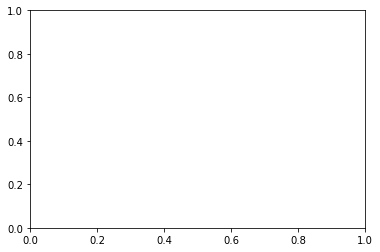

In [23]:
fit_results_1D = []
for fit_result in fit_results:
    fit_results_1D.append(fit_result.x)
    
fit_results_1D = np.concatenate(fit_results_1D)
    
all_columns_initial_params_1D = np.concatenate(all_columns_initial_params)

mplplot.scatter(fit_results_1D,all_columns_initial_params_1D)
mplplot.xlabel("Fit Results")
mplplot.ylabel("Initial Parameters")
mplplot.title("Fit Vs. Initial Parameters Plot ")

### Testing fitted Spectra against original input

In [ ]:
with apfits.open(file_name) as test:
    data = test["SCI"].data.T
    display(trimmed_dfxLowToHigh.index)
    
    nbins = 500
#     print(trimmed_dfx1stLowToHigh.loc[11,"Direct_Y"])
    for source in range(len(trimmed_dfxLowToHigh['Direct_X'])):
        test_trace_input_data = np.sum(data[int(trimmed_dfxLowToHigh.loc[source,"Direct_X"])-2 : int(trimmed_dfxLowToHigh.loc[source,"Direct_X"])+2],axis=0)
        
        # Rebinning Spectra
        
        new_wavs = np.linspace(0,len(test_trace_input_data), nbins)
        binned_fluxes, binned_errors = spectres.spectres(new_wavs, np.arange(len(test_trace_input_data)), result[source], spec_errs=result_err[source], fill=None, verbose=False)
        # print(binned_fluxes.shape,binned_errors.shape)
        mplplot.figure(source)
        mplplot.plot(test_trace_input_data, label="Data")
        mplplot.errorbar(np.arange(len(binned_fluxes))*2048/nbins,binned_fluxes,yerr=binned_errors,label='Fit',ecolor='k')
        # mplplot.errorbar(range(len(binned_fluxes)),binned_fluxes,yerr=binned_errors)#,label='Fit',alpha=1,ecolor='k')
        mplplot.plot(data[int(trimmed_dfxLowToHigh.Direct_X[source])],label='Init Params')
        mplplot.xlabel("Column Number")
        mplplot.ylabel("ADU (e$^{-1}$)")
        mplplot.title(f"Trace Number {source}, Fengwu ID = {trimmed_dfxLowToHigh.FengwuID[source]}")
        mplplot.legend()
        if test_trace_input_data.max() > 20:
            mplplot.ylim(0,1.5)
# See slight differences from data to fits as fit is from 25 rows where as data is sum of 4 rows across all columns
# Sharp peak at ~1400 unknown why this is happening (could be simulated CR hit)
# Added original errors and see more sudden unexpected peaks but fit still moved from initial params